# DonorsChoose.org Application Screening
### Implementing Logistic Regression classification model to predict whether a teachers' project proposal will be approved or not, using the text of project descriptions as well as additional metadata about the project, teacher, and school. 

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
    <li>How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

# 0. Importing libraries 

In [1]:
# import libraries 

%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
#-------------------------------------------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#-------------------------------------------# 
import sqlite3 
import nltk
import string
import re
import pickle
#-------------------------------------------# 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#-------------------------------------------# 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
#-------------------------------------------#
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
#-------------------------------------------# 
from collections import Counter
from tqdm import tqdm
import os
#-------------------------------------------#
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#--------------------------------------------#
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# mount google drive 

from google.colab import drive 
drive.mount('/content/gdrive')

# 1. Reading Data

In [3]:
# data can be downloaded from here -> https://www.kaggle.com/c/donorschoose-application-screening/data

# reading data from google drive 

mypath = '/content/gdrive/My Drive/Donors_Choose_Dataset/'
project_data = pd.read_csv(mypath + 'train_data.csv')
resource_data = pd.read_csv(mypath + 'resources.csv')

In [5]:
# teacher data columns

print(project_data.shape)
print("- "*50)
print(project_data.columns.values)

(109248, 17)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [6]:
# resource data columns

print(resource_data.shape)
print("- "*50)
print(resource_data.columns.values)

(1541272, 4)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
['id' 'description' 'quantity' 'price']


In [7]:
# randomly sample 80000 datapoints from the project_data 

project_data = project_data.sample(n = 50000, random_state = 96)

In [8]:
# sampled data 

print("Number of data points in the data :", project_data.shape)
print('- '*50)
print("Attributes :", project_data.columns.values)

Number of data points in the data : (50000, 17)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Attributes : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


> ## Exploratory Data Analysis : 
Exploratory Data Analysis is considered ad first step towards any Data science project. 
I have performed extensive Data analysis and t-SNE visualization on DonorsChoose dataset that can be found here :  
https://github.com/pratiknabriya/T-SNE_DonorsChoose/blob/master/EDA_TSNE_DonorsChoose.ipynb

# 2. Data Cleaning and Pre-processing 

In [9]:
# checking for class imbalance 

project_data['project_is_approved'].value_counts()

1    42401
0     7599
Name: project_is_approved, dtype: int64

The approved projects are almost 6 times of rejected projects. The dataset is imbalanced. 

## 2.1 Sorting data as per date-time 

In [10]:
# sorting data as per date-time

new_cols = ['date' if i == 'project_submitted_datetime' else i for i in list(project_data.columns)] # in-place modifying the column name of 'date' column
project_data['date'] = pd.to_datetime(project_data['project_submitted_datetime']) # supplying date values to this new column
project_data.drop('project_submitted_datetime', axis = 1, inplace = True) # dropping redundant existing datetime column

# re-order columns 
project_data = project_data[new_cols]
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
54946,153462,p050276,19840b94a506527c92cf5e400f9cbcf1,Ms.,CA,2016-12-27 14:26:51,Grades PreK-2,Applied Learning,Early Development,Learning supplies for my kindergarten students.,"As a Kindergarten teacher, I have a lot of the...",21st century teaching has made me aware of the...,NaN,NaN,My students need supplies and hands on activit...,1,1
83344,967,p240033,e8b239d53a23ea9fcbbcee399f81ee30,Mrs.,IL,2016-04-29 14:49:12,Grades PreK-2,"Health & Sports, Special Needs","Health & Wellness, Special Needs",Wanted! Stand Up Desks for Primary Special Edu...,I teach in a K-2 Emotional Disability classroo...,My students all have an identified emotional d...,I envision the use of stand up desks as a way ...,By donating to this project you will help me b...,My students need four stand up desks.,1,1


In [11]:
 # sort dataframe in ascending order based on date-time

project_data.sort_values(by = ['date'], inplace = True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
29891,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs.,CA,2016-04-27 01:10:09,Grades 3-5,"Math & Science, History & Civics","Mathematics, Social Sciences",Breakout Box to Ignite Engagement!,It's the end of the school year. Routines have...,"My students desire challenges, movement, and c...",I will design different clues using specific c...,Donations to this project will immediately imp...,"My students need items from a \""Breakout Box\""...",6,1
81565,95963,p155767,e50367a62524e11fbd2dc79651b6df21,Mrs.,CA,2016-04-27 01:29:58,Grades 3-5,"Literacy & Language, Math & Science","Literacy, Mathematics",Flexible Seating: An Environment to Help Kids ...,"\""Sitting still is overrated. It makes sense f...","We are a room full of bright, curious, innovat...",We will use this new and modern furniture to h...,Getting and keeping students engaged is perhap...,My students need flexible seating options that...,0,1


## 2.2 Categorical Data 

### 2.2.1 `teacher_prefix`

In [12]:
project_data['teacher_prefix'].value_counts(dropna = False)

Mrs.       26298
Ms.        17745
Mr.         4889
Teacher     1059
Dr.            8
NaN            1
Name: teacher_prefix, dtype: int64

In [13]:
project_data[project_data['teacher_prefix'].isnull()][:1]  

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
57654,158692,p197901,e4be6aaaa887d4202df2b647fbfc82bb,NaN,PA,2016-06-03 10:15:05,Grades 3-5,"Literacy & Language, Math & Science","Literacy, Mathematics",Document Camera,Students at Robertsdale Elementary live in a l...,This SMART Document Camera will improve my stu...,NaN,NaN,My students need a Smart Document Camera to en...,0,1


We see that there are few rows in the data where teacher prefix is NA.

In [14]:
project_data['teacher_prefix'].fillna('NA', inplace = True) # treat null/NAN as a seperate category
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.', '') # remove full stop at the end
project_data['teacher_prefix'].value_counts()

Mrs        26298
Ms         17745
Mr          4889
Teacher     1059
Dr             8
NA             1
Name: teacher_prefix, dtype: int64

In [15]:
project_data['teacher_prefix'].isnull().sum()

0

### 2.2.2` school_state `

In [16]:
project_data['school_state'].value_counts(dropna = False)

CA    7107
NY    3377
TX    3353
FL    2830
NC    2313
IL    1985
GA    1828
SC    1823
PA    1426
MI    1394
MO    1219
IN    1182
OH    1145
MA    1130
LA    1084
OK    1061
NJ    1047
WA    1046
AZ     947
VA     944
WI     824
AL     823
UT     790
TN     776
CT     727
MD     661
NV     621
KY     610
MS     604
MN     565
OR     555
AR     511
CO     484
ID     323
IA     285
KS     267
NM     266
DC     249
HI     235
WV     228
ME     207
NE     162
DE     160
AK     153
SD     150
NH     145
RI     135
MT     107
ND      60
WY      40
VT      36
Name: school_state, dtype: int64

No further processing required 

### 2.2.3 `project_grade_category`

In [17]:
project_data['project_grade_category'].value_counts(dropna = False)

Grades PreK-2    20276
Grades 3-5       16992
Grades 6-8        7753
Grades 9-12       4979
Name: project_grade_category, dtype: int64

In [18]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')
project_data['project_grade_category'].value_counts()

Grades_PreK_2    20276
Grades_3_5       16992
Grades_6_8        7753
Grades_9_12       4979
Name: project_grade_category, dtype: int64

### 2.2.4 `project_subject_category`

In [ ]:
project_data['project_subject_categories'].value_counts(dropna = False)[:10]

Literacy & Language                      17147
Math & Science                           12628
Literacy & Language, Math & Science      10781
Health & Sports                           7397
Music & The Arts                          3762
Special Needs                             3048
Literacy & Language, Special Needs        2906
Applied Learning                          2735
Math & Science, Literacy & Language       1736
Applied Learning, Literacy & Language     1579
Name: project_subject_categories, dtype: int64

In [19]:
# stripping word from string -> https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# remove all whitespaces -> https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
# remove special chars -> https://stackoverflow.com/a/47301924/4084039

categories = list(project_data['project_subject_categories'].values)

cat_list = [] 
for i in categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # split it in three parts ["Math & Science", "Warmth", "Care & Hunger"] 
        if 'The' in j.split(): # j.split() replaces each "Math & Science" into "Math" "&" "Science" and so on
            j = j.replace('The', '') # remove 'The'
        j = j.replace(' ', '') # "Math & Science" -> "Math&Science"
        temp = temp + j.strip() + ' ' # remove the leading & trailing whitespaces 
        temp = temp.replace('&', '_') # replace '&' with '_'
    cat_list.append(temp.strip())

In [20]:
project_data['clean_categories'] = cat_list
project_data.drop('project_subject_categories', axis = 1, inplace = True) # remove redundant column

In [21]:
project_data['clean_categories'].value_counts()[:10]

Literacy_Language                    10713
Math_Science                          7915
Literacy_Language Math_Science        6758
Health_Sports                         4628
Music_Arts                            2266
SpecialNeeds                          1877
Literacy_Language SpecialNeeds        1835
AppliedLearning                       1704
Math_Science Literacy_Language        1080
AppliedLearning Literacy_Language     1000
Name: clean_categories, dtype: int64

In [22]:
# count of all the words in corpus. Reference: https://stackoverflow.com/a/22898595/4084039

my_counter = Counter()

for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key = lambda kv: kv[1]))
sorted_cat_dict

{'AppliedLearning': 5533,
 'Care_Hunger': 641,
 'Health_Sports': 6519,
 'History_Civics': 2760,
 'Literacy_Language': 23962,
 'Math_Science': 19164,
 'Music_Arts': 4611,
 'SpecialNeeds': 6246,
 'Warmth': 641}

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

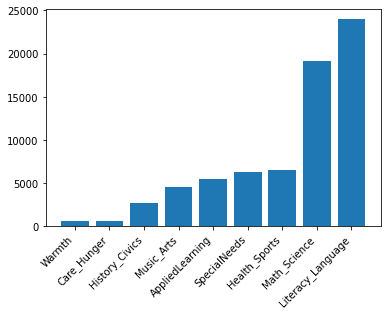

In [23]:
plt.bar(sorted_cat_dict.keys(), height = sorted_cat_dict.values())
plt.xticks(fontsize = 10, rotation = 45, ha = 'right')

### 2.2.5 `project_subject_subcategories`

In [24]:
sub_categories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_categories:
    temp = ""
    for j in i.split(','):  
        if 'The' in j.split():
            j = j.replace('The', '') 
        j = j.replace(' ','') 
        temp = temp + j.strip() + ' '
        temp = temp.replace('&', '_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis = 1, inplace = True)

In [25]:
my_counter2 = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter2.update(word.split())

sub_cat_dict = dict(my_counter2)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key = lambda kv: kv[1]))
sorted_sub_cat_dict

{'AppliedSciences': 5029,
 'Care_Hunger': 641,
 'CharacterEducation': 917,
 'Civics_Government': 364,
 'College_CareerPrep': 1119,
 'CommunityService': 206,
 'ESL': 2028,
 'EarlyDevelopment': 1964,
 'Economics': 112,
 'EnvironmentalScience': 2590,
 'Extracurricular': 377,
 'FinancialLiteracy': 295,
 'ForeignLanguages': 406,
 'Gym_Fitness': 2053,
 'Health_LifeScience': 1934,
 'Health_Wellness': 4697,
 'History_Geography': 1462,
 'Literacy': 15411,
 'Literature_Writing': 10143,
 'Mathematics': 12971,
 'Music': 1396,
 'NutritionEducation': 624,
 'Other': 1102,
 'ParentInvolvement': 324,
 'PerformingArts': 897,
 'SocialSciences': 907,
 'SpecialNeeds': 6246,
 'TeamSports': 1000,
 'VisualArts': 2809,
 'Warmth': 641}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], <a list of 30 Text major ticklabel objects>)

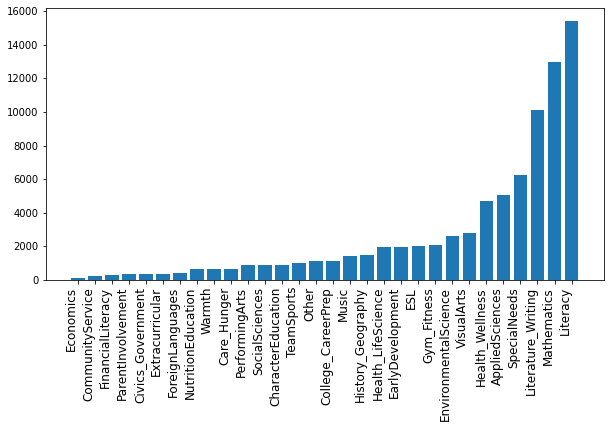

In [30]:
plt.figure(figsize = (10, 5))
plt.bar(sorted_sub_cat_dict.keys(), height = sorted_sub_cat_dict.values())
plt.xticks(fontsize = 12, rotation = 90, ha = 'right')

In [31]:
# check if the above preprocessing setps are implemented well on the dataset
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
29891,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs,CA,2016-04-27 01:10:09,Grades_3_5,Breakout Box to Ignite Engagement!,It's the end of the school year. Routines have...,"My students desire challenges, movement, and c...",I will design different clues using specific c...,Donations to this project will immediately imp...,"My students need items from a \""Breakout Box\""...",6,1,Math_Science History_Civics,Mathematics SocialSciences
81565,95963,p155767,e50367a62524e11fbd2dc79651b6df21,Mrs,CA,2016-04-27 01:29:58,Grades_3_5,Flexible Seating: An Environment to Help Kids ...,"\""Sitting still is overrated. It makes sense f...","We are a room full of bright, curious, innovat...",We will use this new and modern furniture to h...,Getting and keeping students engaged is perhap...,My students need flexible seating options that...,0,1,Literacy_Language Math_Science,Literacy Mathematics


## 2.3 Text Data 

In [32]:
# merge all four essays together into a single column

project_data['essay'] = project_data['project_essay_1'].map(str) + project_data['project_essay_2'].map(str) + \
                        project_data['project_essay_3'].map(str) + project_data['project_essay_4'].map(str)

# drop the redundant essay columns 

project_data.drop(['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'], axis = 1, inplace = True)

In [33]:
# printing some random essays

print(project_data['essay'].values[9])
print('- '*50)
print(project_data['essay'].values[99])
print('- '*50)
print(project_data['essay'].values[999])
print('- '*50)
print(project_data['essay'].values[9999])
print('- '*50)

Throughout this school year, I hope to enable my students to develop a love for reading, discovering, and creating. Students in my classroom have the opportunity to explore learning through large group activities, small group learning times, and interactive play with other students and teachers.My school is a Pre-K through 8 school with teachers and staff who are determined to help children in Detroit succeed. Students in my classroom are just beginning their education in Pre-K and and I strive to enable my students to shine brightly as they learn using the High Scope Curriculum.The shopping carts would be a wonderful addition to our dramatic play area. With them, the children will be able to work on their social skills. They will learn about sharing, purchasing items, and the cost of different items. Similarly, the parachute will be used to encourage cooperative play. The children will have fun learning and exercising. I'm looking forward to adding the beads to our art area in the cla

In [34]:
# decontracting english phrases: https://stackoverflow.com/a/47091490/4084039


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    
    # general 
    phrase = re.sub(r"n\'t", " not",   phrase)
    phrase = re.sub(r"\'re", " are",   phrase)
    phrase = re.sub(r"\'s",  " is",    phrase)
    phrase = re.sub(r"\'d",  " would", phrase)
    phrase = re.sub(r"\'ll", " will",  phrase)
    phrase = re.sub(r"\'t",  " not",   phrase)
    phrase = re.sub(r"\'ve", " have",  phrase)
    phrase = re.sub(r"\'m",  " am",    phrase)
    phrase = re.sub(r"\'em", " them",  phrase)
    return phrase

In [35]:
sent = decontracted(project_data['essay'].values[9999])
print(sent)

My students are special because they are individuals who love learning despite the many challenges they face on an everyday basis. I have witnessed children who have to get themselves up in the morning, children who have to help take care of their brothers and sisters as soon as they get home from school, children who do not understand why mom and dad cannot afford to pay bills, children who do not participate in pajama days because they do not own their own pajamas, children who struggle learning as fast as others and who are afraid every day that they will be teased and bullied. These many children whom I am privileged to teach, lovingly participate in school everyday. These same children, I have witnessed come to school excited about learning. Through their efforts each day they begin to grow in their confidence, they grow in their learning and they even learn beyond the books and begin to understand who they are as individuals.  In my classroom, everyone is unique and we celebrate 

In [36]:
# \r \n \t remove from string python. Reference: http://texthandler.com/info/remove-line-breaks-python/

def remove_linebreaks(sent):
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\t', ' ')
    sent = sent.replace('\\"', ' ')

    return sent

In [37]:
sent = remove_linebreaks(sent)
print(sent)

My students are special because they are individuals who love learning despite the many challenges they face on an everyday basis. I have witnessed children who have to get themselves up in the morning, children who have to help take care of their brothers and sisters as soon as they get home from school, children who do not understand why mom and dad cannot afford to pay bills, children who do not participate in pajama days because they do not own their own pajamas, children who struggle learning as fast as others and who are afraid every day that they will be teased and bullied. These many children whom I am privileged to teach, lovingly participate in school everyday. These same children, I have witnessed come to school excited about learning. Through their efforts each day they begin to grow in their confidence, they grow in their learning and they even learn beyond the books and begin to understand who they are as individuals.  In my classroom, everyone is unique and we celebrate 

In [38]:
# stemming using Porter Stemmer | reference: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

nltk.download('punkt')
def stemming(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence = []
    for word in token_words:
        porter = PorterStemmer()
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [39]:
print(sent)
sent = stemming(sent)
print(sent)

My students are special because they are individuals who love learning despite the many challenges they face on an everyday basis. I have witnessed children who have to get themselves up in the morning, children who have to help take care of their brothers and sisters as soon as they get home from school, children who do not understand why mom and dad cannot afford to pay bills, children who do not participate in pajama days because they do not own their own pajamas, children who struggle learning as fast as others and who are afraid every day that they will be teased and bullied. These many children whom I am privileged to teach, lovingly participate in school everyday. These same children, I have witnessed come to school excited about learning. Through their efforts each day they begin to grow in their confidence, they grow in their learning and they even learn beyond the books and begin to understand who they are as individuals.  In my classroom, everyone is unique and we celebrate 

> Note: Stemming using Porter Stemmer to be done after calculating the sentiment score. 

In [40]:
# remove spacial character: https://stackoverflow.com/a/5843547/4084039

sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My student are special becaus they are individu who love learn despit the mani challeng they face on an everyday basi I have wit children who have to get themselv up in the morn children who have to help take care of their brother and sister as soon as they get home from school children who do not understand whi mom and dad can not afford to pay bill children who do not particip in pajama day becaus they do not own their own pajama children who struggl learn as fast as other and who are afraid everi day that they will be teas and bulli these mani children whom I am privileg to teach lovingli particip in school everyday these same children I have wit come to school excit about learn through their effort each day they begin to grow in their confid they grow in their learn and they even learn beyond the book and begin to understand who they are as individu In my classroom everyon is uniqu and we celebr those differ In my classroom everyon ha a voic and everyon is import My student and my 

In [41]:
# removing all the stopwords (except 'no', 'nor' and 'not') https://gist.github.com/sebleier/554280
# adding 'nannan' to the list of stopwords 

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'could', 'would',\
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "nannan"] # added nannan

In [42]:
# printing some random project_title

print(project_data['project_title'].values[9])
print('- '*50)
print(project_data['project_title'].values[99])
print('- '*50)
print(project_data['project_title'].values[999])
print('- '*50)
print(project_data['project_title'].values[9999])
print('- '*50)

Pre-K Classroom Materials
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Beautifying a Science Classroom
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Math Talks
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
IPads for the Classroom!
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [43]:
# printing some random project_resource_summary

print(project_data['project_resource_summary'].values[9])
print('- '*50)
print(project_data['project_resource_summary'].values[99])
print('- '*50)
print(project_data['project_resource_summary'].values[999])
print('- '*50)
print(project_data['project_resource_summary'].values[9999])
print('- '*50)

My students need shopping carts, a parachute, Kidfetti, and beads.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
My students need a variety of different seating options.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
My students need 10 ten frames, 10 geoboards, 6 renkenreks for our math lessons.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
My students need ipads and headphones to be able to learn through technology in my classroom.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


## 2.4 Feature Engineering and Sentiment analysis 

### 2.4.1 Aggregate and merge the `project_data` and `resource_data` datasets

> Join the two-datasets : project_data and resource_data on 'project_id' to pre-process numerical data 'price' and 'quantity' for further processing. 

In [45]:
# aggregate total price and total quantity per id 

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head()

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [46]:
# merge project_data and price_data datasets 

project_data = pd.merge(project_data, price_data, how = 'left', on = 'id' )
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,date,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
0,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs,CA,2016-04-27 01:10:09,Grades_3_5,Breakout Box to Ignite Engagement!,"My students need items from a \""Breakout Box\""...",6,1,Math_Science History_Civics,Mathematics SocialSciences,It's the end of the school year. Routines have...,102.50,11
1,95963,p155767,e50367a62524e11fbd2dc79651b6df21,Mrs,CA,2016-04-27 01:29:58,Grades_3_5,Flexible Seating: An Environment to Help Kids ...,My students need flexible seating options that...,0,1,Literacy_Language Math_Science,Literacy Mathematics,"\""Sitting still is overrated. It makes sense f...",1418.08,9


### 2.4.2 Introducing new columns -> No. of Words in Project Title, Essay and Project Resource Summary

In [47]:
project_data['title_word_count'] = project_data['project_title'].apply(lambda x: len(x.strip().split()))
project_data['essay_word_count'] = project_data['essay'].apply(lambda x: len(x.strip().split()))
project_data['summary_word_count'] = project_data['project_resource_summary'].apply(lambda x: len(x.strip().split()))

### 2.4.3 Computing Sentiment Score for each combined essay 

In [ ]:
'''
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sentiments = []
sia = SentimentIntensityAnalyzer()
print(project_data['essay'][420])
line = project_data['essay'][420] # take essay row-wise
sentiment = sia.polarity_scores(line)
print(sentiment)
'''

In [48]:
# Reference -> https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def analyze_sentiment(df):
    sentiments = []
    sia = SentimentIntensityAnalyzer()
    for i in range(df.shape[0]):
        line = df['essay'].iloc[i] # take each essay row-wise
        sentiment = sia.polarity_scores(line) # calculate the sentiment
        sentiments.append([sentiment['neg'], sentiment['pos'],
                           sentiment['neu'], sentiment['compound']]) # list of lists
    df[['neg', 'pos', 'neu', 'compound']] = pd.DataFrame(sentiments)
    df['Negative'] = df['compound'] < -0.1 
    df['Negative'] = df['Negative'].map(int) # True = 1, False = 0
    df['Positive'] = df['compound'] > 0.1  
    df['Positive'] = df['Positive'].map(int) # True = 1, False = 0
    return df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [49]:
project_data = analyze_sentiment(project_data)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,date,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity,title_word_count,essay_word_count,summary_word_count,neg,pos,neu,compound,Negative,Positive
0,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs,CA,2016-04-27 01:10:09,Grades_3_5,Breakout Box to Ignite Engagement!,"My students need items from a \""Breakout Box\""...",6,1,Math_Science History_Civics,Mathematics SocialSciences,It's the end of the school year. Routines have...,102.50,11,5,285,27,0.010,0.200,0.790,0.9961,0,1
1,95963,p155767,e50367a62524e11fbd2dc79651b6df21,Mrs,CA,2016-04-27 01:29:58,Grades_3_5,Flexible Seating: An Environment to Help Kids ...,My students need flexible seating options that...,0,1,Literacy_Language Math_Science,Literacy Mathematics,"\""Sitting still is overrated. It makes sense f...",1418.08,9,8,281,27,0.015,0.333,0.652,0.9990,0,1


### 2.4.4 Cleaning Essays

In [50]:
# Cleaning Essays 

preprocessed_essays = []

for sentence in tqdm(project_data['essay'].values): # tqdm is for printing the status bar
    sent = decontracted(sentence) 
    sent = remove_linebreaks(sent)
    sent = stemming(sent)
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent) 
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.strip())

100%|██████████| 50000/50000 [07:03<00:00, 118.00it/s]


In [51]:
project_data['preprocessed_essay'] = preprocessed_essays
project_data.drop(['essay'], axis = 1, inplace = True)  # drop the redundant column 

### 2.4.5 Cleaning Project Title

In [52]:
# combining all the above functions & statements just like above

preprocessed_title = []

for title in tqdm(project_data['project_title'].values): # tqdm is for printing the status bar
    title = decontracted(title)
    title = stemming(title)
    title = re.sub('[^A-Za-z0-9]+', ' ', title) 
    title = ' '.join(e.lower() for e in title.split() if e.lower() not in stopwords)
    preprocessed_title.append(title.strip())

100%|██████████| 50000/50000 [00:14<00:00, 3541.64it/s]


In [53]:
project_data['preprocessed_title'] = preprocessed_title
project_data.drop(['project_title'], axis = 1, inplace = True) # project_title is now redundant. drop the 'project_title' column

### 2.4.6 Cleaning Project Resource Summary

In [54]:
# adding words like 'students', 'need' that are either common throughout or doesn't serve purpose. 

custom_stopwords = stopwords + ['need', 'student'] # note that students will be student post stemming

In [55]:
# combining all the above functions & statements 

preprocessed_summary = []

for summary in tqdm(project_data['project_resource_summary'].values):
    summary = decontracted(summary)
    summary = stemming(summary)
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary) 
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in custom_stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 50000/50000 [00:37<00:00, 1336.21it/s]


In [56]:
project_data['preprocessed_summary'] = preprocessed_summary
project_data.drop(['project_resource_summary'], axis = 1, inplace = True) # drop extra column

### 2.4.7 Cleaning numerical features 

In [57]:
# checking for null values in the numerical features 

print(project_data['price'].isnull().sum())
print(project_data['quantity'].isnull().sum())
print(project_data['teacher_number_of_previously_posted_projects'].isnull().sum())

0
0
0


No Further pre-processing needed. Feature Scaling will be handled later.

### 2.4.8 Remove other redundant columns

In [58]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'date', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'price', 'quantity',
       'title_word_count', 'essay_word_count', 'summary_word_count', 'neg',
       'pos', 'neu', 'compound', 'Negative', 'Positive', 'preprocessed_essay',
       'preprocessed_title', 'preprocessed_summary'],
      dtype='object')

In [59]:
# when you have to drop multiple columns, input them in form of list

project_data.drop(["Unnamed: 0", "id", "teacher_id", "date", "neu"], axis = 1, inplace = True)  

# we remove 'neutral' sentiment as it is already been taken into account internally while computing compound score

In [60]:
# final preprocessed dataset 

project_data.head(2)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,title_word_count,essay_word_count,summary_word_count,neg,pos,compound,Negative,Positive,preprocessed_essay,preprocessed_title,preprocessed_summary
0,Mrs,CA,Grades_3_5,6,1,Math_Science History_Civics,Mathematics SocialSciences,102.50,11,5,285,27,0.010,0.200,0.9961,0,1,end school year routin run cours student need ...,breakout box ignit engag,item breakout box includ differ type lock pen ...
1,Mrs,CA,Grades_3_5,0,1,Literacy_Language Math_Science,Literacy Mathematics,1418.08,9,8,281,27,0.015,0.333,0.9990,0,1,sit still overr make sens opera medit classroo...,flexibl seat environ help kid learn,flexibl seat option allow work person best abi...


## 2.5 Preparing Data for model - Data encoding and featurization

1. For further processing we are going to consider below attributes for training a model :

       CATEGORICAL DATA
       - teacher_prefix
       - school_state 
       - project_grade_category 
       - clean_categories 
       - clean_subcategories 
        
       TEXT DATA
       - project_title 
       - essay
       - project_resource_summary
       
       NUMERICAL DATA
       - teacher_number_of_previously_posted_projects 
       - quantity 
       - price
       
        * additionaly for one set, we'll also consider the newly created word count and sentiment features 
       
2. Also, note that I've considered random 50k datapoints sampled from the dataset of 109k datapoints.

In [61]:
# check if any null values still exist 

project_data.isnull().sum()

teacher_prefix                                  0
school_state                                    0
project_grade_category                          0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
clean_categories                                0
clean_subcategories                             0
price                                           0
quantity                                        0
title_word_count                                0
essay_word_count                                0
summary_word_count                              0
neg                                             0
pos                                             0
compound                                        0
Negative                                        0
Positive                                        0
preprocessed_essay                              0
preprocessed_title                              0
preprocessed_summary                            0


### 2.5.1 Splitting data into Train-Validation-Test dataset

In [62]:
# seperate the response variable(class label) from the other predictors(independent variables) 

y = project_data['project_is_approved']
X = project_data.drop(['project_is_approved'], axis = 1)

In [63]:
# train-cv-test split 
from sklearn.model_selection import train_test_split 

# stratify means that train & test samples have the same proportions of class labels as the input dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

In [64]:
# train-test

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(35000, 19) (35000,)
(15000, 19) (15000,)


### 2.5.2 Encoding Categorical Variables 

#### 2.5.2.1 One-hot-encoding: `teacher_prefix `

In [65]:
vectorizer = CountVectorizer(lowercase = False)
vectorizer.fit(X_train['teacher_prefix'].values) # Note: fit has to happen only on train data
print(vectorizer.get_feature_names()) # get the feature names 

# we use the fitted CountVectorizer to transform the text into a binary vector
X_train_prefix = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_prefix  = vectorizer.transform(X_test['teacher_prefix'].values)

print('- '*50)
print("After Vectorization")
print(X_train_prefix.shape, y_train.shape)
print(X_test_prefix.shape, y_test.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'NA', 'Teacher']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After Vectorization
(35000, 6) (35000,)
(15000, 6) (15000,)


#### 2.5.2.2 One-hot-encoding: school_state


In [66]:
vectorizer = CountVectorizer(lowercase = False)
vectorizer.fit(X_train['school_state'].values) # Note: fit has to happen only on train data
print(vectorizer.get_feature_names()) # get the feature names 

# we use the fitted CountVectorizer to transform the text into a binary vector
X_train_state = vectorizer.transform(X_train['school_state'].values)
X_test_state  = vectorizer.transform(X_test['school_state'].values)

print('- '*50)
print("After Vectorization")
print(X_train_state.shape, y_train.shape)
print(X_test_state.shape, y_test.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After Vectorization
(35000, 51) (35000,)
(15000, 51) (15000,)


#### 2.5.2.3 One-hot-encoding: `project_grade_category`


In [67]:
vectorizer = CountVectorizer(lowercase = False)
vectorizer.fit(X_train['project_grade_category'].values) 
print(vectorizer.get_feature_names())

X_train_grade = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade  = vectorizer.transform(X_test['project_grade_category'].values)

print('- '*50)
print("After Vectorization")
print(X_train_grade.shape, y_train.shape)
print(X_test_grade.shape, y_test.shape)

['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After Vectorization
(35000, 4) (35000,)
(15000, 4) (15000,)


#### 2.5.2.4 One-hot-encoding: `clean_categories` (project_subject_categories)

In [68]:
vectorizer = CountVectorizer(lowercase = False)
vectorizer.fit(X_train['clean_categories'].values) 
print(vectorizer.get_feature_names())

X_train_cat = vectorizer.transform(X_train['clean_categories'].values)
X_test_cat  = vectorizer.transform(X_test['clean_categories'].values)

print('- '*50)
print("After Vectorization")
print(X_train_cat.shape, y_train.shape)
print(X_test_cat.shape, y_test.shape)

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After Vectorization
(35000, 9) (35000,)
(15000, 9) (15000,)


#### 2.5.2.5 One-hot-encoding: `clean_subcategories ` (project_subject_subcategories)

In [69]:
vectorizer = CountVectorizer(lowercase = False)
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector

X_train_subcat = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_subcat  = vectorizer.transform(X_test['clean_subcategories'].values)

print('- '*50)
print("After Vectorization")
print(X_train_subcat.shape, y_train.shape)
print(X_test_subcat.shape, y_test.shape)

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After Vectorization
(35000, 30) (35000,)
(15000, 30) (15000,)


### 2.5.3 BOW Encoding of Text Features 

#### 2.5.3.1 `project_title`

In [78]:
# BOW transformation of project title
vectorizer = CountVectorizer(min_df = 5, ngram_range = (1, 3), max_features = 5000)
vectorizer.fit(X_train['preprocessed_title'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:10]) 
print(vectorizer.get_feature_names()[-10:])

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['preprocessed_title'].values)
X_test_title_bow = vectorizer.transform(X_test['preprocessed_title'].values)

print('- '*50)
print("After vectorization")
print(X_train_title_bow.shape, y_train.shape)
print(X_test_title_bow.shape, y_test.shape)

['04', '05', '10', '100', '101', '12', '123', '12th', '16', '17']
['young mind', 'young musician', 'young reader', 'young scholar', 'young scientist', 'youth', 'zen', 'zone', 'zoo', 'zoom']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After vectorization
(35000, 5000) (35000,)
(15000, 5000) (15000,)


#### 2.5.3.2 `project_resource_summary`

In [79]:
# BOW transformation of project resource summary
vectorizer = CountVectorizer(min_df = 5, ngram_range = (1, 3), max_features = 5000)
vectorizer.fit(X_train['preprocessed_summary'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:10]) 
print(vectorizer.get_feature_names()[-10:])

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary_bow = vectorizer.transform(X_train['preprocessed_summary'].values)
X_test_summary_bow = vectorizer.transform(X_test['preprocessed_summary'].values)

print('- '*50)
print("After vectorization")
print(X_train_summary_bow.shape, y_train.shape)
print(X_test_summary_bow.shape, y_test.shape)

['10', '10 chromebook', '100', '11', '12', '13', '14', '15', '16', '17']
['yoga mat', 'yoga mat yoga', 'young', 'young adult', 'young reader', 'younger', 'zenergi', 'zenergi ball', 'zenergi ball chair', 'zip']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After vectorization
(35000, 5000) (35000,)
(15000, 5000) (15000,)


#### 2.5.3.3 `essay`

In [80]:
# BOW transformation of essay
vectorizer = CountVectorizer(min_df = 10, max_df = 0.5, ngram_range = (1, 2), max_features = 5000) 
vectorizer.fit(X_train['preprocessed_essay'].values)
print(vectorizer.get_feature_names()[:10]) 
print(vectorizer.get_feature_names()[-10:])

X_train_essay_bow = vectorizer.transform(X_train['preprocessed_essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['preprocessed_essay'].values)

print('- '*50)
print("After vectorization")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)

['000', '10', '10 year', '100', '100 free', '100 percent', '100 student', '11', '12', '12th']
['young learner', 'young men', 'young mind', 'young peopl', 'young student', 'younger', 'younger student', 'youngest', 'youth', 'zone']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
After vectorization
(35000, 5000) (35000,)
(15000, 5000) (15000,)


In [81]:
# top 25 most frequent words in the essay train corpus 
sum_words = X_train_essay_bow.sum(axis = 0) 
words_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda kv: kv[1], reverse = True)
print(words_freq[:25])

[('read', 43296), ('love', 27513), ('class', 27007), ('book', 26659), ('day', 25979), ('year', 25503), ('make', 25362), ('abl', 24403), ('skill', 22386), ('technolog', 22306), ('provid', 21730), ('allow', 21347), ('time', 20925), ('also', 20873), ('want', 20478), ('new', 20333), ('activ', 20247), ('teach', 19712), ('project', 19661), ('grade', 19061), ('get', 18898), ('one', 18422), ('way', 17670), ('opportun', 17270), ('creat', 16927)]


### 2.5.4 TF-IDF Encoding of Text Features


#### 2.5.4.1 `project_title`

In [82]:
# TF-IDF transformation of project title
vectorizer = TfidfVectorizer(min_df = 5, ngram_range = (1, 3), max_features = 5000)
vectorizer.fit(X_train['preprocessed_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['preprocessed_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['preprocessed_title'].values)

print("After vectorization")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)

After vectorization
(35000, 5000) (35000,)
(15000, 5000) (15000,)


#### 2.5.4.2 `project_resource_summary`

In [83]:
# TF-IDF transformation of project resource summary
vectorizer = TfidfVectorizer(min_df = 5, ngram_range = (1,3), max_features = 5000)
vectorizer.fit(X_train['preprocessed_summary'].values) # fit has to happen only on train data

# We use the fitted TfIdfVectorizer to convert the text to vector
X_train_summary_tfidf = vectorizer.transform(X_train['preprocessed_summary'].values)
X_test_summary_tfidf = vectorizer.transform(X_test['preprocessed_summary'].values)

print("After vectorization")
print(X_train_summary_tfidf.shape, y_train.shape)
print(X_test_summary_tfidf.shape, y_test.shape)

After vectorization
(35000, 5000) (35000,)
(15000, 5000) (15000,)


#### 2.5.4.3 `essay`

In [84]:
# TF-IDf transformation of essay
vectorizer = TfidfVectorizer(min_df = 10, max_df = 0.5, ngram_range = (1, 2), max_features = 5000) 
vectorizer.fit(X_train['preprocessed_essay'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essay'].values)

print("After vectorization")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorization
(35000, 5000) (35000,)
(15000, 5000) (15000,)


### 2.5.5 AVG-W2V encoding of text features using pre-trained model 

In [ ]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

In [85]:
# stronging variables into pickle files python:
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file

path = '/content/gdrive/My Drive/Donors_Choose_Dataset/glove_vectors'
with open(path, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [86]:
# Average Word2Vec function

def avg_w2v_vectors(preprocessed_text):
    ''' This function returns the vector for each text using Avg-W2V method'''
    avg_w2v_vectors_text = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_text): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors_text.append(vector)
    return avg_w2v_vectors_text

#### 2.5.5.1 `project_title`

In [88]:
# average word2vec for project title

X_train_title_avgw2v = avg_w2v_vectors(X_train['preprocessed_title'])
X_test_title_avgw2v = avg_w2v_vectors(X_test['preprocessed_title'])

100%|██████████| 15000/15000 [00:00<00:00, 71551.63it/s]


#### 2.5.5.2 `project_resource_summary`

In [89]:
# average word2vec for project resource summary

X_train_summary_avgw2v = avg_w2v_vectors(X_train['preprocessed_summary'])
X_test_summary_avgw2v = avg_w2v_vectors(X_test['preprocessed_summary'])

100%|██████████| 15000/15000 [00:00<00:00, 40387.68it/s]


#### 2.5.5.3 essay

In [90]:
# average word2vec for essay

X_train_essay_avgw2v = avg_w2v_vectors(X_train['preprocessed_essay'])
X_test_essay_avgw2v = avg_w2v_vectors(X_test['preprocessed_essay'])

100%|██████████| 15000/15000 [00:03<00:00, 4094.06it/s]


### 2.5.6 TFIDF weighted W2V encoding of text features using pre-trained model 

In [92]:
# TFIDF weighted Word2Vec function

def tfidf_w2v_vectors(preprocessed_text):
    ''' This function returns the vector for each text using TFIDF-W2V method'''
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_text_words = set(tfidf_model.get_feature_names())

    tfidf_w2v_text = [] # the tfidf-w2v for each sentence is stored in this list
    for sentence in tqdm(preprocessed_text): # for each review/sentence
        vector = np.zeros(300) # initialize a 0 vector of length 300
        tf_idf_weight = 0 # initializing the number of words with valid vector in the review/sentence
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_text_words):
                vec = model[word] # getting the vector for each word
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # multiplying idf value and the tf value
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_text.append(vector)
    return tfidf_w2v_text

#### 2.5.6.1 `project_title`

In [93]:
# computing TFIDF-AVGW2V for project title

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_title']) # use only train vocabulary to fit 

X_train_title_tfidfw2v = tfidf_w2v_vectors(X_train['preprocessed_title'])
X_test_title_tfidfw2v = tfidf_w2v_vectors(X_test['preprocessed_title'])

100%|██████████| 15000/15000 [00:00<00:00, 33536.81it/s]


#### 2.5.6.2 `project_resource_summary`

In [94]:
# computing TFIDF-AVGW2V for project resource summary
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_summary']) # use only train vocabulary to fit 

X_train_summary_tfidfw2v = tfidf_w2v_vectors(X_train['preprocessed_summary'])
X_test_summary_tfidfw2v = tfidf_w2v_vectors(X_test['preprocessed_summary'])

100%|██████████| 15000/15000 [00:01<00:00, 12949.65it/s]


#### 2.5.6.3 `essay`

In [95]:
# computing TFIDF-AVGW2V for essays
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essay']) # fit on train data only

X_train_essay_tfidfw2v = tfidf_w2v_vectors(X_train['preprocessed_essay'])
X_test_essay_tfidfw2v = tfidf_w2v_vectors(X_test['preprocessed_essay'])

100%|██████████| 15000/15000 [00:20<00:00, 721.21it/s]


### 2.5.7 Scaling Numerical Features

#### 2.5.7.1 `price`

In [108]:
project_data['price'].describe()

count    50000.000000
mean       296.936552
std        370.821194
min          0.660000
25%        104.907500
50%        206.415000
75%        378.490000
max       9999.000000
Name: price, dtype: float64

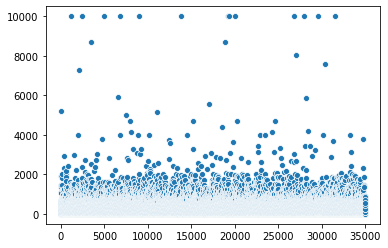

In [109]:
sns.scatterplot(data = X_train['price'].values)

In [110]:
# We'll be using MinMaxScaler on the numerical features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train['price'].values.reshape(-1, 1)) # fit on train data

X_train_price = scaler.transform(X_train['price'].values.reshape(-1,1))
X_test_price = scaler.transform(X_test['price'].values.reshape(-1,1))

print("After vectorization")
print(X_train_price.shape, y_train.shape)
print(X_test_price.shape, y_test.shape)

After vectorization
(35000, 1) (35000,)
(15000, 1) (15000,)


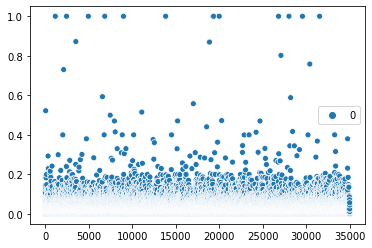

In [111]:
sns.scatterplot(data = X_train_price)

#### 2.5.7.2 `quantity`

In [112]:
project_data['quantity'].describe()

count    50000.000000
mean        16.957400
std         26.229912
min          1.000000
25%          4.000000
50%          9.000000
75%         21.000000
max        930.000000
Name: quantity, dtype: float64

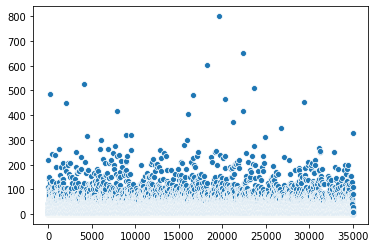

In [113]:
sns.scatterplot(data = X_train['quantity'].values)

In [114]:
# Using MinMax scaler on numerical feature

scaler = MinMaxScaler()
scaler.fit(X_train['quantity'].values.reshape(-1, 1))

X_train_quantity = scaler.transform(X_train['quantity'].values.reshape(-1, 1))
X_test_quantity = scaler.transform(X_test['quantity'].values.reshape(-1, 1))

print("After vectorization")
print(X_train_quantity.shape, y_train.shape)
print(X_test_quantity.shape, y_test.shape)

After vectorization
(35000, 1) (35000,)
(15000, 1) (15000,)


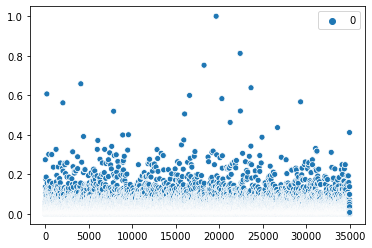

In [116]:
sns.scatterplot(data = X_train_quantity)

#### 2.5.7.3 `teacher_number_of_previously_posted_projects`

In [117]:
project_data['teacher_number_of_previously_posted_projects'].describe()

count    50000.000000
mean        11.103920
std         27.728397
min          0.000000
25%          0.000000
50%          2.000000
75%          9.000000
max        437.000000
Name: teacher_number_of_previously_posted_projects, dtype: float64

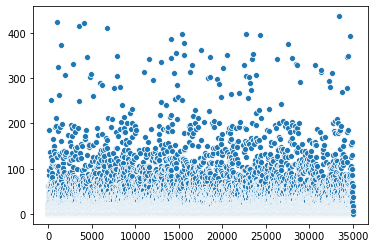

In [118]:
sns.scatterplot(data = X_train['teacher_number_of_previously_posted_projects'].values)

In [119]:
# Using MinMax scaler on numerical feature

scaler = MinMaxScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_proj = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_proj = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print('After vectorization')
print(X_train_prev_proj.shape, y_train.shape)
print(X_test_prev_proj.shape, y_test.shape)

After vectorization
(35000, 1) (35000,)
(15000, 1) (15000,)


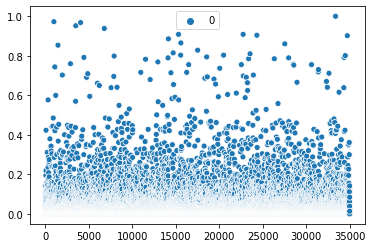

In [120]:
sns.scatterplot(data = X_train_prev_proj)

### 2.5.8 Merging all the above vectorized features

#### 2.5.8.1 Set 1: Categorical, Numerical features  +  project_title(BOW)  +  preprocessed_essay (BOW)  +  project_resource_summary(BOW)

In [121]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# we are concatinating a sparse matrix and a dense matirx using hstack
X_train_bow = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat,
                      X_train_title_bow, X_train_summary_bow, X_train_essay_bow,
                      X_train_price, X_train_prev_proj, X_train_quantity))

X_test_bow = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                     X_test_title_bow, X_test_summary_bow, X_test_essay_bow,
                     X_test_price, X_test_prev_proj, X_test_quantity))

#### 2.5.8.2 Set 2: Categorical, Numerical features  +  project_title(TFIDF)  +  preprocessed_essay(TFIDF)  +  project_resource_summary(TFIDF)

In [122]:
X_train_tfidf = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat,
                        X_train_title_tfidf, X_train_summary_tfidf, X_train_essay_tfidf,
                        X_train_price, X_train_prev_proj, X_train_quantity))
                     

X_test_tfidf = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                       X_test_title_tfidf, X_test_summary_tfidf, X_test_essay_tfidf,
                       X_test_price, X_test_prev_proj, X_test_quantity))

#### 2.5.8.3 Set 3: Categorical, Numerical features  +  project_title(Avg-W2V)  +  preprocessed_essay(Avg-W2V)  +  project_resource_summary(Avg-W2V)

In [123]:
X_train_avgw2v = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat,
                        X_train_title_avgw2v, X_train_summary_avgw2v, X_train_essay_avgw2v,
                        X_train_price, X_train_prev_proj, X_train_quantity))
                     
X_test_avgw2v = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                       X_test_title_avgw2v, X_test_summary_avgw2v, X_test_essay_avgw2v,
                       X_test_price, X_test_prev_proj, X_test_quantity))

#### 2.5.8.4 Set 4: Categorical, Numerical features  +  project_title(TFIDF-W2V)  +  preprocessed_essay(TFIDF-W2V)  +  project_resource_summary(TFIDF-W2V)

In [124]:
X_train_tfidfw2v = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat,
                        X_train_title_tfidfw2v, X_train_summary_tfidfw2v, X_train_essay_tfidfw2v,
                        X_train_price, X_train_prev_proj, X_train_quantity))
                     
X_test_tfidfw2v = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                       X_test_title_tfidfw2v, X_test_summary_tfidfw2v, X_test_essay_tfidfw2v,
                       X_test_price, X_test_prev_proj, X_test_quantity))

# 3. Implementing Logistic Regression Classification model

## 3.1 Logistic Regression (brute) on Set 1 with BOW vectorized text data

### 3.1.1 Hyperparameter tuning using Grid Search technique with 5-fold CV

In [125]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight = 'balanced') # default penalty is L2
parameter = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} # setting hyperparameter from 10^-4 to 10^4 in powers of 10
clf = GridSearchCV(lr, parameter, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf.fit(X_train_bow, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

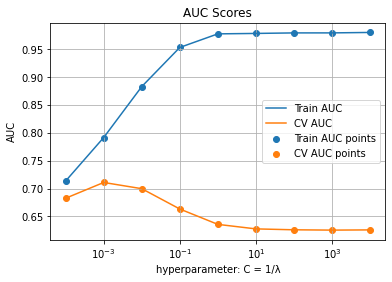

In [126]:
# Plotting AUC_Scores for train data and CV data to determine optimal hyperparameter

#sns.set_style("ticks")
train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
plt.plot(parameter['C'], train_auc, label = 'Train AUC')
plt.plot(parameter['C'], cv_auc, label = 'CV AUC')

plt.scatter(parameter['C'], train_auc, label = 'Train AUC points')
plt.scatter(parameter['C'], cv_auc, label = 'CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("hyperparameter: C = 1/λ")
plt.ylabel("AUC")
plt.title("AUC Scores")
plt.grid()
plt.show()

> * It can be observed that as the Hyperparameter C increases, the variance increases rapidly and we get very high AUC score on the Train data implying that the model overfits. 

> * The optimal C value as seen from the above plot is 10^-3 which has highest AUC score on CV data and Train Score is also resonable. 

> C = 0.001 is the best hyperparameter 

### 3.1.2 Training model with optimal hyperparameter

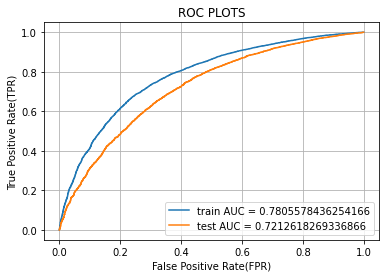

In [128]:
# plot the ROC curve using the besk C value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(C = 0.001, class_weight= 'balanced') # default penalty is L2 
clf.fit(X_train_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = sig_clf.predict_proba(X_train_bow)[:, 1]
y_test_pred = sig_clf.predict_proba(X_test_bow)[:, 1] 
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC = "+str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.grid()
plt.show()

In [129]:
print("Train AUC Score : ", round(auc(train_fpr, train_tpr),3))
print("Test AUC Score: ", round(auc(test_fpr, test_tpr),3))

Train AUC Score :  0.781
Test AUC Score:  0.721


### 3.1.3 Confusion Matrix 

> Note that we are defining function for predicting with pre-defined threshold. **We will pick a threshold such that it gives least False Positive Rate (FPR).**

In [130]:
# function to determine the optimal threshold value 

def find_best_threshold(thresholds, fpr, tpr):
    ''' this function finds the best threshold '''
    t = thresholds[np.argmax(tpr*(1 - fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The max value of tpr*(1-fpr) is", np.round(max(tpr*(1 - fpr)), 3), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    ''' This function makes predictions against the best threshold value''' 
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [131]:
# train and test thresholds 
train_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)

The max value of tpr*(1-fpr) is 0.514 for threshold 0.839
The max value of tpr*(1-fpr) is 0.444 for threshold 0.84


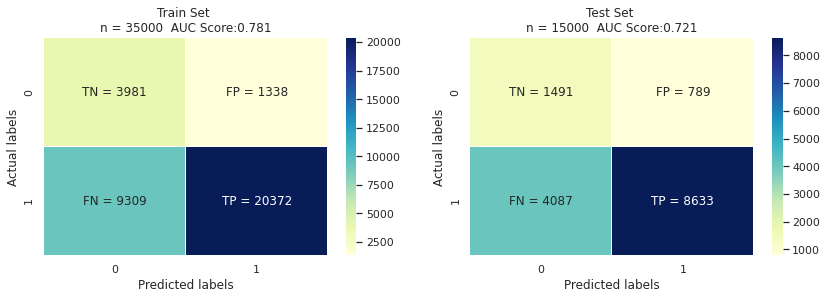

In [132]:
# Visualizing train and test confusion matrix using Seaborn heatmap 
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
# https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/

y_tr_pred = predict_with_best_t(y_train_pred, train_threshold)
y_te_pred = predict_with_best_t(y_test_pred, test_threshold)

sns.set()                    
cm_train = confusion_matrix(y_train, y_tr_pred)
cm_test = confusion_matrix(y_test, y_te_pred)
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1,2, figsize=(14, 4))
train_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(), 
                           cm_train.flatten())])).reshape(2, 2)
test_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(),
                          cm_test.flatten())])).reshape(2, 2)

sns.heatmap(cm_train, linewidths=.25, annot = train_label, fmt = '', ax = ax[0], cmap = 'YlGnBu')
sns.heatmap(cm_test, linewidths=.25, annot = test_label, fmt = '', ax = ax[1], cmap = 'YlGnBu')

ax[0].set_xlabel('Predicted labels'); ax[0].set_ylabel('Actual labels')
ax[1].set_xlabel('Predicted labels'); ax[1].set_ylabel('Actual labels')
ax[0].set_title('Train Set \nn = {0}  AUC Score:{1:.3f}'.format(X_train.shape[0], round(auc(train_fpr, train_tpr),3)))
ax[1].set_title('Test Set \nn = {0}  AUC Score:{1:.3f}'.format(X_test.shape[0], round(auc(test_fpr, test_tpr),3)))
plt.show()

## 3.2 Logistic Regression (brute) on Set 2 with TFIDF vectorized text data

### 3.2.1 Hyperparameter tuning using Grid Search technique with 5-fold CV

In [133]:
lr = LogisticRegression(class_weight = 'balanced') # default penalty is L2
parameter = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} # setting hyperparameter from 10^-4 to 10^4 in powers of 10
clf = GridSearchCV(lr, parameter, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

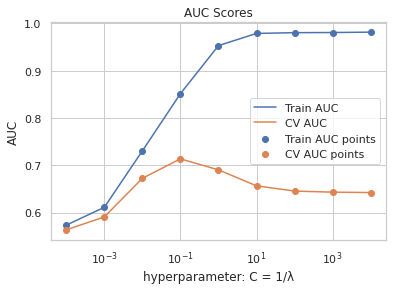

In [137]:
# Plotting AUC Scores for train data and CV data to determine optimal hyperparameter

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
plt.plot(parameter['C'], train_auc, label = 'Train AUC')
plt.plot(parameter['C'], cv_auc, label = 'CV AUC')

plt.scatter(parameter['C'], train_auc, label = 'Train AUC points')
plt.scatter(parameter['C'], cv_auc, label = 'CV AUC points')
plt.xscale('log') 

sns.set(style = 'whitegrid')
plt.legend()
plt.xlabel("hyperparameter: C = 1/λ")
plt.ylabel("AUC")
plt.title("AUC Scores")
plt.show()

> * It can be observed that as the Hyperparameter C increases, the variance increases rapidly and we get very high AUC score on the Train data implying that the model overfits. 

> * The optimal C value as seen from the above plot is 10^-1 which has highest AUC score on CV data and Train Score is also resonable. 

> C = 0.1 is the best hyperparameter 

### 3.2.2 Training model with optimal hyperparameter

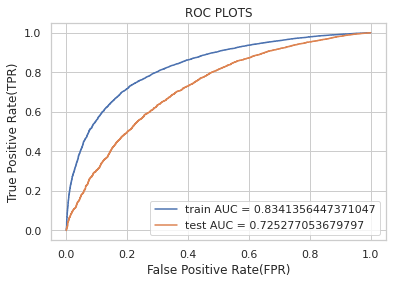

In [139]:
# plot the ROC curve using the best C value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

clf = LogisticRegression(C = 0.1, class_weight = 'balanced') # default penalty is L2 
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = sig_clf.predict_proba(X_train_tfidf)[:,1]
y_test_pred = sig_clf.predict_proba(X_test_tfidf)[:,1] 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC = "+str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

In [140]:
print("Train AUC Score : ", round(auc(train_fpr, train_tpr),3))
print("Test AUC Score: ", round(auc(test_fpr, test_tpr),3))

Train AUC Score :  0.834
Test AUC Score:  0.725


### 3.2.3 Confusion Matrix 

> Note that we are defining function for predicting with pre-defined threshold. We will pick a threshold such that it gives least False Positive Rate (FPR).

In [141]:
# train and test thresholds 
train_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)

The max value of tpr*(1-fpr) is 0.578 for threshold 0.835
The max value of tpr*(1-fpr) is 0.448 for threshold 0.842


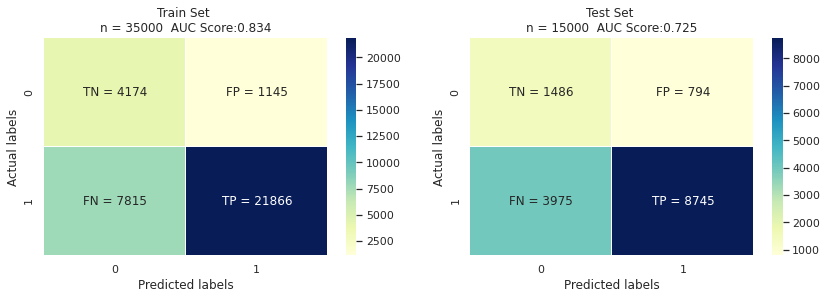

In [142]:
# Visualizing train and test confusion matrix using Seaborn heatmap 
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
# https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/

y_tr_pred = predict_with_best_t(y_train_pred, train_threshold)
y_te_pred = predict_with_best_t(y_test_pred, test_threshold)

sns.set()                    
cm_train = confusion_matrix(y_train, y_tr_pred)
cm_test = confusion_matrix(y_test, y_te_pred)
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1,2, figsize=(14, 4))
train_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(), 
                           cm_train.flatten())])).reshape(2,2)
test_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(),
                          cm_test.flatten())])).reshape(2,2)

sns.heatmap(cm_train, linewidths=.25, annot = train_label, fmt = '', ax = ax[0], cmap = 'YlGnBu')
sns.heatmap(cm_test, linewidths=.25, annot = test_label, fmt = '', ax=ax[1], cmap = 'YlGnBu')

ax[0].set_xlabel('Predicted labels'); ax[0].set_ylabel('Actual labels')
ax[1].set_xlabel('Predicted labels'); ax[1].set_ylabel('Actual labels')
ax[0].set_title('Train Set \nn = {0}  AUC Score:{1:.3f}'.format(X_train.shape[0], round(auc(train_fpr, train_tpr),3)))
ax[1].set_title('Test Set \nn = {0}  AUC Score:{1:.3f}'.format(X_test.shape[0], round(auc(test_fpr, test_tpr),3)))
plt.show()

## 3.3 Logistic Regression (brute) on Set 3 with Avg Word2Vec vectorized text data

### 3.3.1 Hyperparameter tuning using Grid Search technique with 5-fold CV

In [143]:
lr = LogisticRegression(class_weight = 'balanced') # default penalty is L2
parameter = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} # setting hyperparameter from 10^-4 to 10^4 in powers of 10
clf = GridSearchCV(lr, parameter, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf.fit(X_train_avgw2v, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

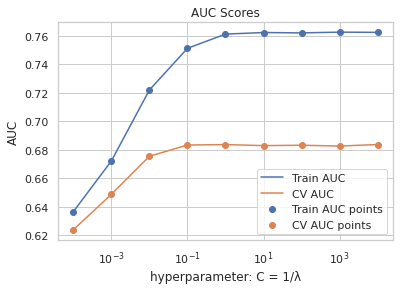

In [145]:
# Plotting AUC Scores for train data and CV data to determine optimal hyperparameter

sns.set(style = 'whitegrid')
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
plt.plot(parameter['C'], train_auc, label = 'Train AUC')
plt.plot(parameter['C'], cv_auc, label = 'CV AUC')

plt.scatter(parameter['C'], train_auc, label = 'Train AUC points')
plt.scatter(parameter['C'], cv_auc, label = 'CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("hyperparameter: C = 1/λ")
plt.ylabel("AUC")
plt.title("AUC Scores")
plt.show()

> * It can be observed that as the Hyperparameter C increases, the variance increases rapidly and we get very high AUC score on the Train data implying that the model overfits. 

> * As seen from the above plot for C = 10^-1 and C = 1, the Test AUC Scores are nearly equal. 

In [146]:
hyperparams = clf.cv_results_['params']
for i in range(len(cv_auc)):
    print(hyperparams[i], cv_auc[i])

{'C': 0.0001} 0.623952010150832
{'C': 0.001} 0.6488290058466091
{'C': 0.01} 0.6755339721023003
{'C': 0.1} 0.6834203738383187
{'C': 1} 0.6837196126117966
{'C': 10} 0.6830022906122704
{'C': 100} 0.6832601015600501
{'C': 1000} 0.6827092366533519
{'C': 10000} 0.6837485367789432


> C = 1 is the best hyperparameter 

### 3.3.2 Training model with optimal hyperparameter 

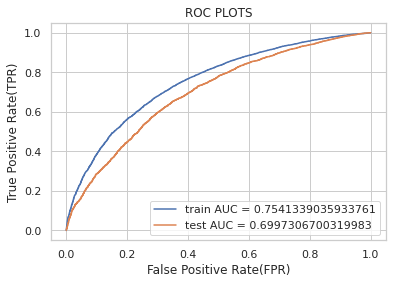

In [149]:
# plot the ROC curve using the besk C value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

clf = LogisticRegression(C = 1, class_weight = 'balanced') # default penalty is L2 
clf.fit(X_train_avgw2v, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(X_train_avgw2v, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = sig_clf.predict_proba(X_train_avgw2v)[:, 1]
y_test_pred = sig_clf.predict_proba(X_test_avgw2v)[:, 1] 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC = "+str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

In [150]:
print("Train AUC Score : ", round(auc(train_fpr, train_tpr),3))
print("Test AUC Score: ", round(auc(test_fpr, test_tpr),3))

Train AUC Score :  0.754
Test AUC Score:  0.7


### 3.3.3 Confusion Matrix 

> Note that we are defining function for predicting with pre-defined threshold. We will pick a threshold such that it gives least False Positive Rate (FPR).

In [151]:
# train and test thresholds 
train_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)

The max value of tpr*(1-fpr) is 0.476 for threshold 0.841
The max value of tpr*(1-fpr) is 0.425 for threshold 0.842


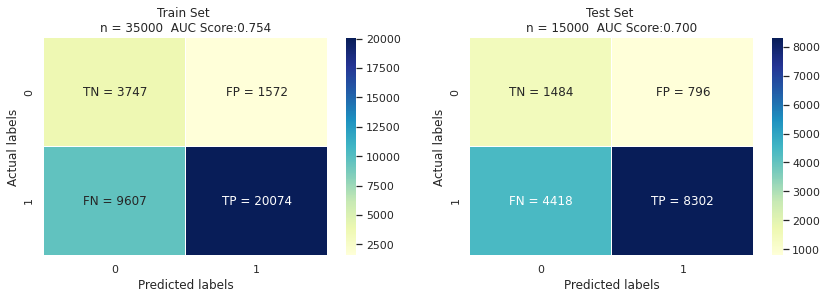

In [152]:
# Visualizing Train and Test Confusion matrix using Seaborn heatmap 
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
# https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/

y_tr_pred = predict_with_best_t(y_train_pred, train_threshold)
y_te_pred = predict_with_best_t(y_test_pred, test_threshold)

cm_train = confusion_matrix(y_train, y_tr_pred)
cm_test = confusion_matrix(y_test, y_te_pred)
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
train_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(), 
                           cm_train.flatten())])).reshape(2,2)
test_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(),
                          cm_test.flatten())])).reshape(2,2)

sns.heatmap(cm_train, linewidths=.25, annot = train_label, fmt = '', ax = ax[0], cmap = 'YlGnBu')
sns.heatmap(cm_test, linewidths=.25, annot = test_label, fmt = '', ax = ax[1], cmap = 'YlGnBu')

ax[0].set_xlabel('Predicted labels'); ax[0].set_ylabel('Actual labels')
ax[1].set_xlabel('Predicted labels'); ax[1].set_ylabel('Actual labels')
ax[0].set_title('Train Set \nn = {0}  AUC Score:{1:.3f}'.format(X_train.shape[0], round(auc(train_fpr, train_tpr),3)))
ax[1].set_title('Test Set \nn = {0}  AUC Score:{1:.3f}'.format(X_test.shape[0], round(auc(test_fpr, test_tpr),3)))
plt.show()

## 3.4 Logistic Regression (brute) on Set 4 with TFIDF-weighted Word2Vec vectorized text data

### 3.4.1 Hyperparameter tuning using Grid Search technique with 5-fold CV

In [153]:
lr = LogisticRegression(class_weight = 'balanced') # default penalty is L2
parameter = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} # setting hyperparameter from 10^-4 to 10^4 in powers of 10
clf = GridSearchCV(lr, parameter, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf.fit(X_train_tfidfw2v, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

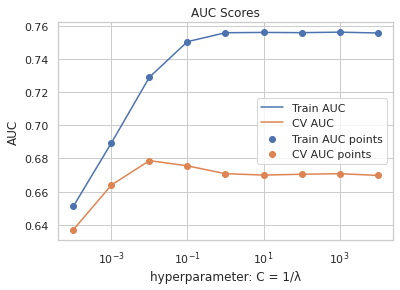

In [156]:
# Plotting Train & CV AUC Scores 

sns.set_style("whitegrid")
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
plt.plot(parameter['C'], train_auc, label = 'Train AUC')
plt.plot(parameter['C'], cv_auc, label = 'CV AUC')

plt.scatter(parameter['C'], train_auc, label = 'Train AUC points')
plt.scatter(parameter['C'], cv_auc, label = 'CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("hyperparameter: C = 1/λ")
plt.ylabel("AUC")
plt.title("AUC Scores")
plt.show()

> * It can be observed that as the Hyperparameter C increases, the variance increases rapidly and we get very high AUC score on the Train data implying that the model overfits. 

> * The optimal C value as seen from the above plot is 10^-2 which has highest AUC score on CV data and Train Score is also resonable. 

> C = 0.01 is the best hyperparameter 

### 3.4.2 Training model with optimal hyperparameter

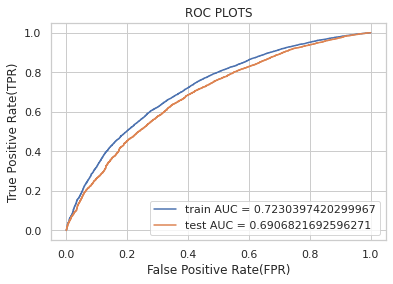

In [157]:
# plot the ROC curve using the besk C value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(C = 0.01, class_weight= 'balanced') # default penalty is L2 
clf.fit(X_train_tfidfw2v, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(X_train_tfidfw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = sig_clf.predict_proba(X_train_tfidfw2v)[:, 1]
y_test_pred = sig_clf.predict_proba(X_test_tfidfw2v)[:, 1] 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC = "+str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

In [158]:
print("Train AUC Score : ", round(auc(train_fpr, train_tpr),3))
print("Test AUC Score: ", round(auc(test_fpr, test_tpr),3))

Train AUC Score :  0.723
Test AUC Score:  0.691


### 3.4.3 Confusion Matrix 

> Note that we are defining function for predicting with pre-defined threshold. We will pick a threshold such that it gives least False Positive Rate (FPR).

In [159]:
# train and test thresholds 
train_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)

The max value of tpr*(1-fpr) is 0.441 for threshold 0.839
The max value of tpr*(1-fpr) is 0.415 for threshold 0.844


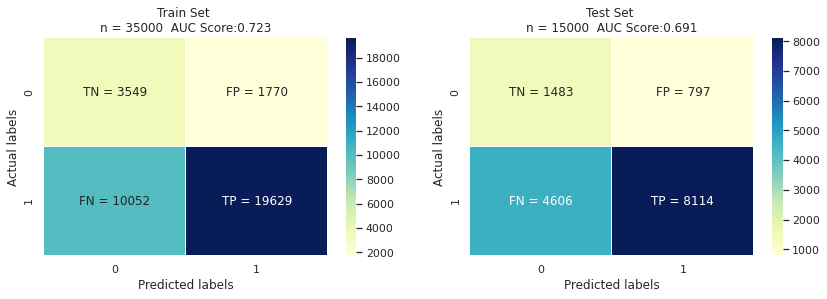

In [160]:
# Visualizing train and test confusion matrix using Seaborn heatmap 
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
# https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/

y_tr_pred = predict_with_best_t(y_train_pred, train_threshold)
y_te_pred = predict_with_best_t(y_test_pred, test_threshold)

sns.set()                    
cm_train = confusion_matrix(y_train, y_tr_pred)
cm_test = confusion_matrix(y_test, y_te_pred)
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
train_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(), 
                           cm_train.flatten())])).reshape(2, 2)
test_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(),
                          cm_test.flatten())])).reshape(2, 2)

sns.heatmap(cm_train, linewidths=.25, annot = train_label, fmt = '', ax = ax[0], cmap = 'YlGnBu')
sns.heatmap(cm_test, linewidths=.25, annot = test_label, fmt = '', ax=ax[1], cmap = 'YlGnBu')

ax[0].set_xlabel('Predicted labels'); ax[0].set_ylabel('Actual labels')
ax[1].set_xlabel('Predicted labels'); ax[1].set_ylabel('Actual labels')
ax[0].set_title('Train Set \nn = {0}  AUC Score:{1:.3f}'.format(X_train.shape[0], round(auc(train_fpr, train_tpr),3)))
ax[1].set_title('Test Set \nn = {0}  AUC Score:{1:.3f}'.format(X_test.shape[0], round(auc(test_fpr, test_tpr),3)))
plt.show()

## 3.5 Logistic Regression (brute) on Set 5 with only Categorical and Numerical features 
### (This is an experimental set to determine how the prediction is affected by replacing the text data with newly engineered features - word count and Sentiment Score) 

### 3.5.1 Normalizing all remainingnumerical features 

#### 3.5.1.1` title_word_count`

In [162]:
project_data['title_word_count'].describe()

count    50000.000000
mean         5.138880
std          2.101933
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         13.000000
Name: title_word_count, dtype: float64

In [163]:
norm = MinMaxScaler()

norm.fit(X_train['title_word_count'].values.reshape(-1,1))

X_train_title_count = norm.transform(X_train['title_word_count'].values.reshape(-1,1))
X_test_title_count = norm.transform(X_test['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_title_count.shape, y_train.shape)
print(X_test_title_count.shape, y_test.shape)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### 3.5.1.2 `essay_word_count`

In [165]:
project_data['essay_word_count'].describe()

count    50000.000000
mean       255.235440
std         65.515162
min        119.000000
25%        203.000000
50%        237.000000
75%        292.000000
max        501.000000
Name: essay_word_count, dtype: float64

In [166]:
norm = MinMaxScaler()

norm.fit(X_train['essay_word_count'].values.reshape(-1,1))

X_train_essay_count = norm.transform(X_train['essay_word_count'].values.reshape(-1,1))
X_test_essay_count = norm.transform(X_test['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_essay_count.shape, y_train.shape)
print(X_test_essay_count.shape, y_test.shape)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### 3.5.1.3 `summary_word_count`

In [167]:
project_data['summary_word_count'].describe()

count    50000.000000
mean        20.230920
std          7.790128
min          4.000000
25%         14.000000
50%         18.000000
75%         26.000000
max        137.000000
Name: summary_word_count, dtype: float64

In [168]:
norm = MinMaxScaler()

norm.fit(X_train['summary_word_count'].values.reshape(-1,1))

X_train_summary_count = norm.transform(X_train['summary_word_count'].values.reshape(-1,1))
X_test_summary_count = norm.transform(X_test['summary_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_summary_count.shape, y_train.shape)
print(X_test_summary_count.shape, y_test.shape)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### 3.5.1.4 pos sentiment score

This is already in range [0,1]

In [169]:
X_train_pos = X_train['pos'].values.reshape(-1,1)
X_test_pos = X_test['pos'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_pos.shape, y_train.shape)
print(X_test_pos.shape, y_test.shape)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### 3.5.1.5 neg sentiment score

This is already in range [0,1]

In [170]:
X_train_neg = X_train['neg'].values.reshape(-1,1)
X_test_neg = X_test['neg'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_neg.shape, y_train.shape)
print(X_test_neg.shape, y_test.shape)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### 3.5.1.6 compound sentiment score

This is in range [-1,1], we'll bring it in range [0,1] just like other features above

In [171]:
norm = MinMaxScaler()

norm.fit(X_train['compound'].values.reshape(-1,1))
X_train_comp = norm.transform(X_train['compound'].values.reshape(-1,1))
X_test_comp = norm.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_comp.shape, y_train.shape)
print(X_test_comp.shape, y_test.shape)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


### 3.5.2 Merging all the above Normalized numerical features with the previously encoded categorical features 

In [174]:
# merge two sparse matrices
from scipy.sparse import hstack

# we are concatenating a sparse matrix and a dense matirx using hstack
X_train_new = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat,
                      X_train_price, X_train_prev_proj, X_train_quantity,
                      X_train_title_count, X_train_essay_count, X_train_summary_count,
                      X_train_pos, X_train_neg, X_train_comp))

X_test_new = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat,
                      X_test_price, X_test_prev_proj, X_test_quantity,
                      X_test_title_count, X_test_essay_count, X_test_summary_count,
                      X_test_pos, X_test_neg, X_test_comp))

### 3.5.3 Hyperparameter tuning using Grid Search technique with 5-fold CV

In [175]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight = 'balanced') # default penalty is L2
parameter = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} # setting hyperparameter from 10^-4 to 10^4 in powers of 10
clf = GridSearchCV(lr, parameter, cv = 5, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf.fit(X_train_new, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

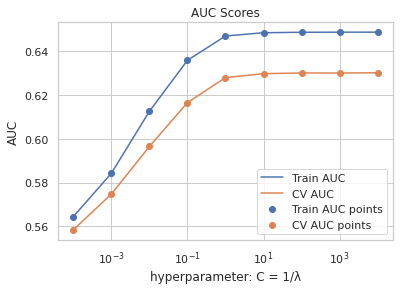

In [177]:
# Plotting Train & CV AUC Scores 

sns.set(style = 'whitegrid')
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
plt.plot(parameter['C'], train_auc, label = 'Train AUC')
plt.plot(parameter['C'], cv_auc, label = 'CV AUC')

plt.scatter(parameter['C'], train_auc, label = 'Train AUC points')
plt.scatter(parameter['C'], cv_auc, label = 'CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("hyperparameter: C = 1/λ")
plt.ylabel("AUC")
plt.title("AUC Scores")
plt.show()

> * It can be observed that as the Hyperparameter C increases, the variance increases rapidly and we get very high AUC score on the Train data implying that the model overfits. 

> * The optimal C value as seen from the above plot is 100, thereafter the AUC Score becomes almost constant. From experience, taking higher value of C would result in an an overfitting model. 

> C = 100 is the best hyperparameter 

### 3.5.4 Training model with optimal hyperparameter 

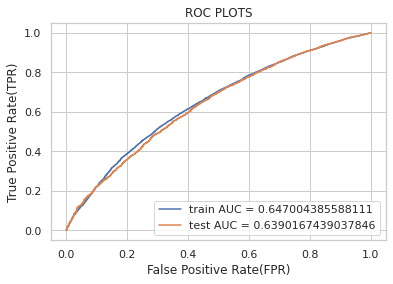

In [179]:
# plot the ROC curve using the besk C value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

clf = LogisticRegression(C = 100, class_weight= 'balanced') # default penalty is L2 
clf.fit(X_train_new, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(X_train_new, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs
y_train_pred = sig_clf.predict_proba(X_train_new)[:,1]
y_test_pred = sig_clf.predict_proba(X_test_new)[:,1] 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

In [180]:
print("Train AUC Score : ", round(auc(train_fpr, train_tpr),3))
print("Test AUC Score: ", round(auc(test_fpr, test_tpr),3))

Train AUC Score :  0.647
Test AUC Score:  0.639


### 3.5.5 Confusion Matrix 

> Note that we are defining function for predicting with pre-defined threshold. We will pick a threshold such that it gives least False Positive Rate (FPR).

In [181]:
# train and test thresholds 
train_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)

The max value of tpr*(1-fpr) is 0.37 for threshold 0.847
The max value of tpr*(1-fpr) is 0.362 for threshold 0.846


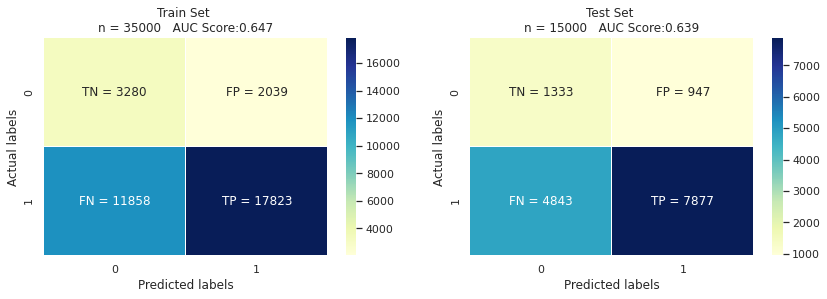

In [182]:
# Visualizing train and test confusion matrix using Seaborn heatmap 
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
# https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/

y_tr_pred = predict_with_best_t(y_train_pred, train_threshold)
y_te_pred = predict_with_best_t(y_test_pred, test_threshold)

sns.set()                    
cm_train = confusion_matrix(y_train, y_tr_pred)
cm_test = confusion_matrix(y_test, y_te_pred)
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1,2, figsize=(14, 4))
train_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(), 
                           cm_train.flatten())])).reshape(2,2)
test_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(),
                          cm_test.flatten())])).reshape(2,2)

sns.heatmap(cm_train, linewidths=.25, annot = train_label, fmt = '', ax = ax[0], cmap = 'YlGnBu')
sns.heatmap(cm_test, linewidths=.25, annot = test_label, fmt = '', ax=ax[1], cmap = 'YlGnBu')

ax[0].set_xlabel('Predicted labels'); ax[0].set_ylabel('Actual labels')
ax[1].set_xlabel('Predicted labels'); ax[1].set_ylabel('Actual labels')
ax[0].set_title('Train Set \nn = {0}   AUC Score:{1:.3f}'.format(X_train.shape[0], round(auc(train_fpr, train_tpr), 3)))
ax[1].set_title('Test Set \nn = {0}   AUC Score:{1:.3f}'.format(X_test.shape[0], round(auc(test_fpr, test_tpr), 3)))
plt.show()

# 4. Conclusion 

In [1]:
# Comparision of all models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ("Set", "Text vectorization", "Model", "Hyperparameter: C" ,"AUC_Score")
table.add_row(["1", "BOW", "Logistic Regression\n", 0.001, 0.721])
table.add_row(["2", "TF-IDF", "Logistic Regression\n", 0.1, 0.725])
table.add_row(["3", "AVG-W2V", "Logistic Regression\n", 1, 0.7])
table.add_row(["4", "TFIDF-W2V", "Logistic Regression\n", 0.01, 0.691])
table.add_row(["5", "Categorical & \nNumerical features only", "Logistic Regression", 100, 0.639])
print(table)

+-----+-------------------------+---------------------+-------------------+-----------+
| Set |    Text vectorization   |        Model        | Hyperparameter: C | AUC_Score |
+-----+-------------------------+---------------------+-------------------+-----------+
|  1  |           BOW           | Logistic Regression |       0.001       |   0.721   |
|     |                         |                     |                   |           |
|  2  |          TF-IDF         | Logistic Regression |        0.1        |   0.725   |
|     |                         |                     |                   |           |
|  3  |         AVG-W2V         | Logistic Regression |         1         |    0.7    |
|     |                         |                     |                   |           |
|  4  |        TFIDF-W2V        | Logistic Regression |        0.01       |   0.691   |
|     |                         |                     |                   |           |
|  5  |      Categorical &      

> * The AUC Score is found be highest for the Model 1 trained on the dataset with TF-IDF vectorized text data. This AUC Score is almost equal to the model with BOW vectorized text.
 
> * In expermiental set (Model 5) to determine the importance of the text features in our classification, by replacing each text feature with respective numerical features like word_count, sentiment score etc., we got a relatively low AUC Score indicating that text data plays an important role in classification. 